# Minneapolis: On-Sale Liquor Licenses
## ETL and Analysis of On Sale Liquor Licenses
Details:
| Title           | Description                                                    |
|-----------------|----------------------------------------------------------------|
| Author          | Kymberly Ayodeji                                               |
| Start Date      | 2024-05-23                                                     |
| End Date        | 2024-                                                          |
| Datasets        | Minneapolis OpenData: [On-Sale Liquor Licenses](https://opendata.minneapolismn.gov/datasets/cityoflakes::on-sale-liquor/about)                                            |
| Products        |                                                                |
| Summary         |                                                                |

### 0: Install Libraries and Packages

In [22]:
# Import Packages and Libraries needed for the project
import pandas as pd
import numpy as np

# for data processing
import requests
import json

# for Geospatial data
import geopandas as gpd 

# for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import contextily

### 1: Load Data

In [2]:
def a_load_data(url):
    # Load GeoPandas data from OpenData.Minneapolis.Gov open On-Sale Liquor Licenses in the City of Minneapolis
    response = requests.get(url)
    data = json.loads(response.text)
    # since the data contains nested dictionaries we need to flatten the data from the outer features key
    data2 = pd.json_normalize(data['features'])
    # Rename the nested dictionary keys of geometry and  properties columns by removing geometry and properties.
    data2.columns = data2.columns.str.replace('geometry.', '')
    data2.columns = data2.columns.str.replace('properties.', '')
    return data2

In [3]:
url = "https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/On_Sale_Liquor/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
raw_data = a_load_data(url)
raw_data.head()

,type,id,type,coordinates,apn,OBJECTID,licenseNumber,licenseType,licenseStatus,liquorType,...,licenseName,address,endorsements,ward,neighborhood,lat,long,xWebMercator,yWebMercator,lastUpdateDate
0,Feature,1,Point,"[-93.2847375971601, 44.9338328058106]",1002824220002,1,LIC404929,BLWine,Approved,On Sale,...,Clancey's,3804 GRAND AVE S,"Wine, On Sale, Add Strong Beer; Wine, On Sale...",8,King Field,44.93383,-93.28474,-1.038441e+07,5.611111e+06,1683483324000
1,Feature,2,Point,"[0, 0]",None,2,LIC406561,BLLiquor,Approved,On Sale,...,Relish,700 CENTRAL AVE NE #A,"Liquor, On Sale, No Entertainment",None,None,0.00000,0.00000,0.000000e+00,0.000000e+00,1692555320000
2,Feature,3,Point,"[-93.2783961299563, 44.9558276679095]",3402924240117,3,LIC406659,BLLiquor,Approved,On Sale,...,Luna & The Bear,18 26TH ST W,"Liquor, On Sale, No Entertainment",10,Whittier,44.95583,-93.27840,-1.038370e+07,5.614570e+06,1692555320000
3,Feature,4,Point,"[-93.2487267506189, 45.0051783248442]",1402924110004,4,LIC394260,BLWine,Approved,On Sale,...,Strike Theater,824 18TH AVE NE,"Wine, On Sale, General Entertainment; Wine, O...",1,Logan Park,45.00518,-93.24873,-1.038040e+07,5.622337e+06,1683483324000
4,Feature,5,Point,"[-93.3014949806758, 44.9917854099267]",1602924340140,5,LIC80410,BLLiquor,Pending,On Sale,...,Elk's Lounge,1614 PLYMOUTH AVE N,"Liquor, On Sale, Bottle Club",5,Near - North,44.99179,-93.30149,-1.038627e+07,5.620228e+06,1605723317000


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            285 non-null    object 
 1   id              285 non-null    int64  
 2   type            285 non-null    object 
 3   coordinates     285 non-null    object 
 4   apn             279 non-null    object 
 5   OBJECTID        285 non-null    int64  
 6   licenseNumber   285 non-null    object 
 7   licenseType     285 non-null    object 
 8   licenseStatus   285 non-null    object 
 9   liquorType      285 non-null    object 
 10  issueDate       284 non-null    float64
 11  expirationYear  284 non-null    float64
 12  expirationDate  284 non-null    float64
 13  licenseName     285 non-null    object 
 14  address         285 non-null    object 
 15  endorsements    284 non-null    object 
 16  ward            278 non-null    object 
 17  neighborhood    278 non-null    obj

### 2: Clean Data

In [5]:
def b_clean_data(df):
    num_rows = df.shape[0]
    # Convert coordinates column to two separate columns for the x and y coordinates
    # Separate the pairs into two lists
    df['X'] = [pair[0] for pair in df['coordinates']]
    df['Y'] = [pair[1] for pair in df['coordinates']]
    df['X'] = df['X'].astype('float64')
    df['Y'] = df['Y'].astype('float64')
    
    # Drop columns that are not needed
    cols_not_needed = ['coordinates','type', 'id', 'type', 'OBJECTID','liquorType', 'lat', 'long', 'xWebMercator', 'yWebMercator']
    df.drop(columns=cols_not_needed, inplace=True, axis=1)
   
    # Convert object columns to other data types. Step 1: Fill missing values with 0
    object_columns = ['ward', 'issueDate', 'expirationDate', 'lastUpdateDate']
    df[object_columns] = df[object_columns].fillna(0)
    
    # Convert to integer
    df['ward'] = df['ward'].astype('int64')
    
    # Convert object columns to datetime   
    df['issueDate'] = pd.to_datetime(df['issueDate'], unit='ms')
    df['expirationDate'] = pd.to_datetime(df['expirationDate'], unit='ms') 
    df['lastUpdateDate'] = pd.to_datetime(df['lastUpdateDate'], unit='ms')
   
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Convert expirationYear to integer
    df['expirationYear'] = df['expirationYear'].astype('int64')
    print(f'Dropped {num_rows - df.shape[0]} rows')
    return df

In [6]:
df = b_clean_data(raw_data)
df.head()

Dropped 8 rows


,apn,licenseNumber,licenseType,licenseStatus,issueDate,expirationYear,expirationDate,licenseName,address,endorsements,ward,neighborhood,lastUpdateDate,X,Y
0,1002824220002,LIC404929,BLWine,Approved,2023-05-05 10:08:29,2024,2024-04-01 23:59:59,Clancey's,3804 GRAND AVE S,"Wine, On Sale, Add Strong Beer; Wine, On Sale...",8,King Field,2023-05-07 18:15:24,-93.284738,44.933833
2,3402924240117,LIC406659,BLLiquor,Approved,2023-08-18 00:35:22,2024,2024-04-01 23:59:59,Luna & The Bear,18 26TH ST W,"Liquor, On Sale, No Entertainment",10,Whittier,2023-08-20 18:15:20,-93.278396,44.955828
3,1402924110004,LIC394260,BLWine,Approved,2023-05-05 10:06:26,2024,2024-04-01 23:59:00,Strike Theater,824 18TH AVE NE,"Wine, On Sale, General Entertainment; Wine, O...",1,Logan Park,2023-05-07 18:15:24,-93.248727,45.005178
4,1602924340140,LIC80410,BLLiquor,Pending,2019-08-22 08:49:57,2020,2020-04-01 00:00:00,Elk's Lounge,1614 PLYMOUTH AVE N,"Liquor, On Sale, Bottle Club",5,Near - North,2020-11-18 18:15:17,-93.301495,44.991785
5,2602924120061,LIC404994,BLWine,Approved,2023-07-17 12:44:44,2024,2024-04-01 23:59:59,Milly's Wine Bar & Bistro,1129 WASHINGTON AVE S,"Wine, On Sale, Add Strong Beer; Wine, On Sale...",3,Downtown East,2023-07-18 18:15:20,-93.252228,44.974580


In [7]:
def c_address_messy_data(df):
    num_rows = df.shape[0]
    # Remove data where issue date is less than 2020
    df = df[df['issueDate'].dt.year >= 2010]
    
    # Remove data where expiration date is less than 2020
    df = df[df['expirationDate'].dt.year >= 2020]
    
    # Remove data when the Ward is not 1 to 13
    df= df[df['ward'].between(1, 13)]
    print(f'Rows removed: {num_rows - df.shape[0]}')
    return df

In [8]:
df = c_address_messy_data(df)

Rows removed: 0


In [9]:
def d_feature_engineering(df):
    # Extract month, year from the issue date and calculate the duration of the license
    df['issueMonth'] = df['issueDate'].dt.month
    df['issueYear'] = df['issueDate'].dt.year   
    df['duration'] = df['expirationDate'] - df['issueDate']
    
    # Split up the endorsements column into separate columns
    endorsements = df['endorsements'].str.split('[,;]').explode().unique()
    endorsements = [e.strip() for e in endorsements]
    for e in endorsements:
        df[e] = df['endorsements'].str.contains(e, regex=False)

    return df

In [10]:
df = d_feature_engineering(df)

In [24]:
df.columns

Index(['apn', 'licenseNumber', 'licenseType', 'licenseStatus', 'issueDate',
       'expirationYear', 'expirationDate', 'licenseName', 'address',
       'endorsements', 'ward', 'neighborhood', 'lastUpdateDate', 'X', 'Y',
       'issueMonth', 'issueYear', 'duration', 'Wine', 'On Sale',
       'Add Strong Beer', 'No Entertainment', 'Liquor',
       'General Entertainment', 'Bottle Club', 'Limited Entertainment',
       'Class A', 'Adult Entertainment', 'Class E Entertainment',
       'Taproom Class E Entertainment', 'Taproom No Entertainment',
       'Taproom Class C1 Entertainment', 'Taproom Limited Entertainment',
       'Beer', 'Class C1 Entertainment', 'Class B Entertainment',
       'Class D Entertainment', 'Class A Entertainment', 'Distillery',
       'Class C2 Entertainment', 'BL Sunday Sales Exemption',
       'Culinary Classes'],
      dtype='object')

### 3: Exploratory Data Visualizations 

In [16]:
# Load and Prep the Minneapolis City Council Wards shapefile
def e_load_prep_shapefile(mpls_zip):
    df = gpd.read_file(mpls_zip)
    # Rename column and convert to integer
    df.rename(columns={'BDNUM':'ward'}, inplace=True)
    df['ward']=df['ward'].astype('int64')
    
    return df


In [17]:
mpls_zip = "data/City_Council_Wards-shp.zip" 
mpls_df =e_load_prep_shapefile(mpls_zip)
mpls_df.head()

,FID,ward,Shape_STAr,Shape_STLe,SHAPE_Leng,SHAPE_Area,geometry
0,1,1,2.044159e+08,71797.801731,0.239243,0.002168,"POLYGON ((-93.22685 45.01322, -93.22684 45.013..."
1,2,9,7.290147e+07,42091.446370,0.141295,0.000772,"POLYGON ((-93.24318 44.95583, -93.24304 44.955..."
2,3,3,1.062057e+08,57104.348729,0.188700,0.001126,"POLYGON ((-93.26313 45.01317, -93.26312 45.011..."
3,4,4,1.471704e+08,57462.048968,0.185399,0.001561,"POLYGON ((-93.29920 45.05114, -93.29920 45.051..."
4,5,8,7.869230e+07,47568.406676,0.154032,0.000833,"POLYGON ((-93.27478 44.94835, -93.27477 44.946..."


In [20]:
def f_plot_wards(df):
    # Plot the wards
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(18, 9))
    df.plot(column ='ward', alpha=0.9, legend=False,      #plotting geometry data
        edgecolor = 'white', cmap='viridis', ax=ax)
    df.apply(lambda x: ax.annotate(text = x['ward'],      #annotations
                               xy = x.geometry.centroid.coords[0],
                               color = 'white',
                               ha = 'center'), axis = 1)
    ax = contextily.add_basemap(ax, crs=df.crs.to_string())
    plt.title('Minneapolis Wards')
    plt.show()

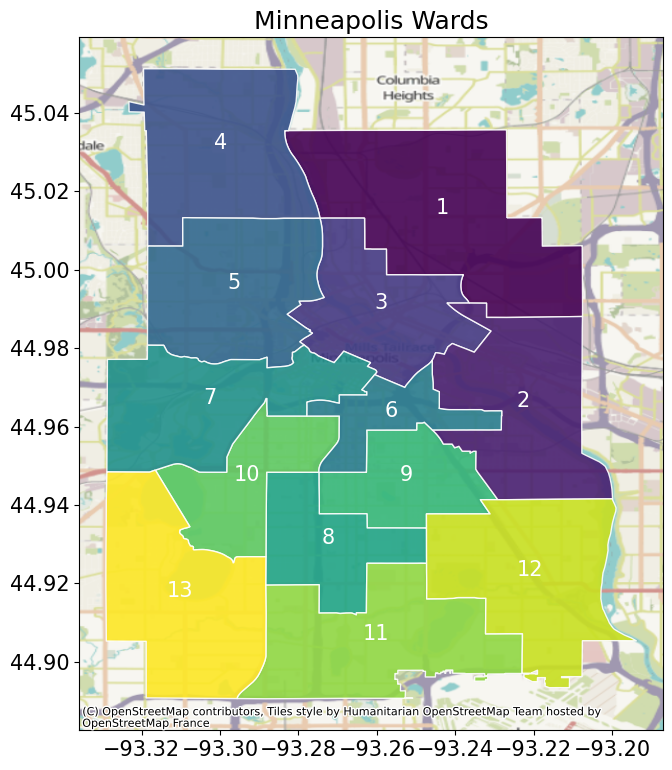

In [23]:
f_plot_wards(mpls_df)

In [58]:
def g_plot_liquor_licenses(df, mpls_df, endorsement = 'Wine'):
    # Plot the wards
    if endorsement not in df.columns:
        endorsement = 'Wine'
    cmap = 'cividis'
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(18, 9))
    mpls_df.plot(column ='ward', alpha=0.9, legend=False,      #plotting geometry data
        edgecolor = 'white', cmap=cmap, ax=ax)
    mpls_df.apply(lambda x: ax.annotate(text = x['ward'],      #annotations
                               xy = x.geometry.centroid.coords[0],
                               color = 'white',
                               ha = 'center'), axis = 1)
    ax = contextily.add_basemap(ax, crs=mpls_df.crs.to_string())
    df_endorsement = df[df[endorsement] == True ]
    cnt = df[endorsement].sum()
    plt.title(f'{endorsement} Locations ({cnt}) in Minneapolis')
    plt.scatter(df_endorsement['X'], df_endorsement['Y'], c=df_endorsement[endorsement], s=10, alpha=0.5)
    plt.show()

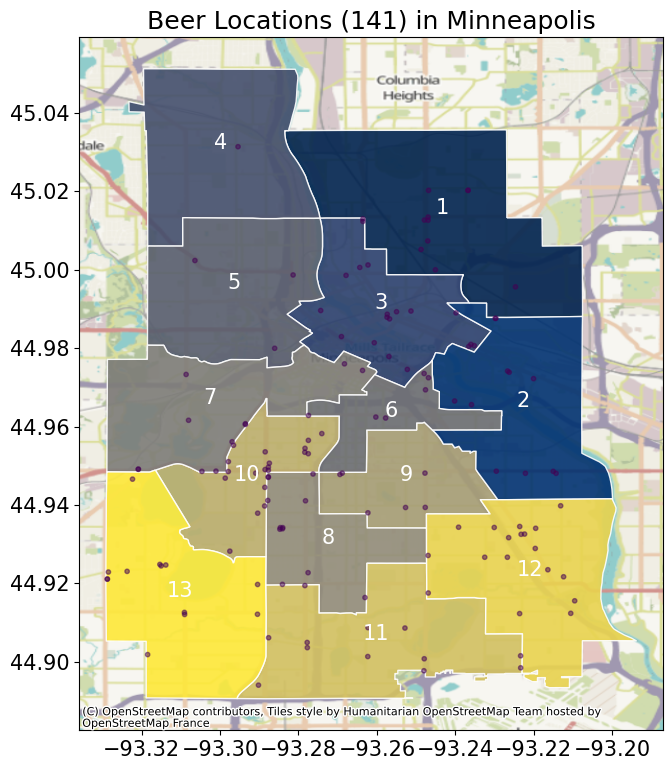

In [59]:
g_plot_liquor_licenses(df,mpls_df, 'Beer')

In [11]:
endorsements = df['endorsements'].str.split('[,;]').explode().unique()
endorsements = [e.strip() for e in endorsements]
df[endorsements].sum().sort_values(ascending=False)

On Sale                           271
No Entertainment                  165
Beer                              141
Wine                              139
Add Strong Beer                   137
Liquor                            128
Class E Entertainment             105
Limited Entertainment              60
General Entertainment              41
Class A                            19
Class A Entertainment              16
Class C1 Entertainment             16
Class B Entertainment              14
Class C2 Entertainment             12
Class D Entertainment               7
Taproom Limited Entertainment       6
BL Sunday Sales Exemption           6
Taproom No Entertainment            5
Bottle Club                         5
Taproom Class C1 Entertainment      4
Adult Entertainment                 3
Taproom Class E Entertainment       2
Distillery                          1
Culinary Classes                    1
dtype: int64

In [12]:
df['licenseName'].str.contains('restaurant', case=False).sum()

22

In [13]:
df['licenseName'].str.contains('bar', case=False).sum()

30

In [14]:
df['licenseName'].str.contains('lounge', case=False).sum()

5

In [15]:
df['licenseName'].head(10)

0                                     Clancey's
2                               Luna & The Bear
3                                Strike Theater
4                                  Elk's Lounge
5                     Milly's Wine Bar & Bistro
6                          Luminary Arts Center
7                                     Dutch Bar
8                     Carbon Kitchen and Market
9                                      Gay 90'S
10    Best of Best Quality Korean Fried Chicken
Name: licenseName, dtype: object